In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

In [2]:
(raw_train, raw_validation, raw_test), metadata = tfds.load('cats_vs_dogs', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                                                   with_info=True, as_supervised=True)

Shuffling and writing examples to /home/ubuntu/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteMV5UCZ/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /home/ubuntu/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [6]:
class_names = metadata.features['label'].names
class_names

['cat', 'dog']

In [7]:
dataset_size = metadata.splits['train'].num_examples
dataset_size

23262

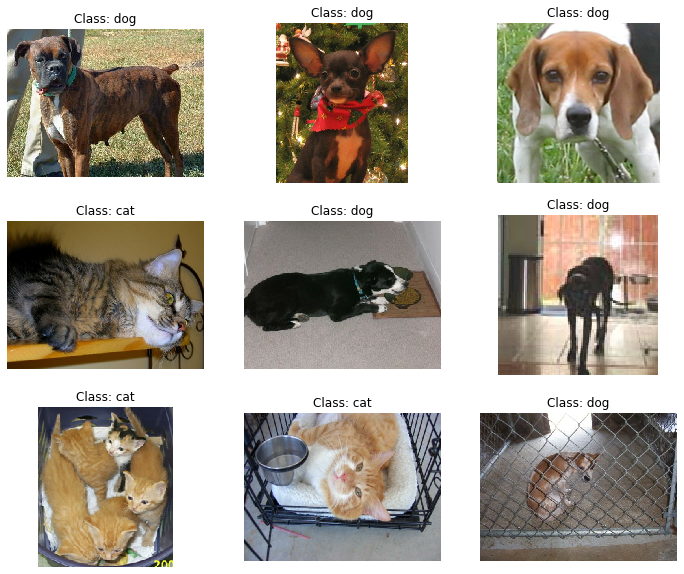

In [8]:
plt.figure(figsize=(12,10))
index=0
for image, label in raw_train.take(9):
    index += 1
    plt.subplot(3,3, index)
    plt.imshow(image)
    plt.title('Class: {}'.format(class_names[label]))
    plt.axis('off')
plt.show()

In [9]:
IMG_SIZE = 160

def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [10]:
train = raw_train.map(preprocess)
valid = raw_validation.map(preprocess)
test = raw_test.map(preprocess)

In [12]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = valid.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [15]:
# for image_batch, _ in train_batches.take(20000):
#     index += 1

In [17]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

9412608/9406464 [==============================] - 3s 0us/step


In [19]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [20]:
base_model.trainable = False

In [22]:
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1),
])

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.RMSprop(lr=base_learning_rate),
             loss=keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [25]:
model.fit(train_batches, epochs=20, validation_data=validation_batches)

Epoch 1/20
    577/Unknown - 401s 694ms/step - loss: 0.3963 - accuracy: 0.7964

KeyboardInterrupt: 